# Using libRadtran in Parallel on a Cluster

This notebook shows how to run a batch of [`libRadtran/uvspec`](http://www.libradtran.org) cases in parallel on a cluster computer using [`dask.distributed`](http://distributed.readthedocs.io/en/latest/limitations.html). 
The `dask.distributed` package provides a flexible, yet reasonably simple way of harnessing mutiple compute cores from the `IPython/Jupyter` notebook environment or in other Python launch modes.

It is somewhat easier to set up and use the `dask.distributed` cluster client than the `ipyparallel` client. However, `dask.distributed` provides even less security and must only be run on local trusted networks. 

This particular example computes the direct horizontal ultraviolet B (UVB, 300 nm to 340 nm) irradiance at Bottom-Of-Atmosphere (BOA) as a function of the solar zenith angle (SZA).



In [1]:
import morticia.rad.librad as librad
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from dask.distributed import Client # For contacting the dask scheduler
# use latex for font rendering
mpl.rcParams['text.usetex'] = True  # Use TeX to format labels (takes a bit longer)
%matplotlib inline

In [41]:
# Load a libRadtran example case
# Be default, any include files are expanded, creating a single set of option keywords
libRadCase=librad.Case(filename='./examples/UVSPEC_AEROSOL.INP')
libRadCase.purge = True

In [42]:
# Show the input of the basecase
libRadCase

atmosphere_file ../data/atmmod/afglus.dat
source solar ../data/solar_flux/atlas_plus_modtran
mol_modify O3 300. DU
day_of_year 170
albedo 0.2
sza 32.0
rte_solver disort
number_of_streams 6
wavelength 299.0 341.0
slit_function_file ../examples/TRI_SLIT.DAT
spline 300 340 1
quiet 
aerosol_vulcan 1
aerosol_haze 6
aerosol_season 1
aerosol_visibility 20.0
aerosol_angstrom 1.1 0.2
aerosol_modify ssa scale 0.85
aerosol_modify gg set 0.70
aerosol_file tau ../examples/AERO_TAU.DAT

In [43]:
# Create 10 copies of the case in a list, with different solar zenith angles
import copy
libRadBatch = [copy.deepcopy(libRadCase) for icopy in range(9)]
# Rename each element in the batch, just by appending a digit
# This is to prevent the engines from fighting over input and output files
# Also change the solar zenith angle on each run, so that they are different
solar_zenith_angle = np.linspace(0.0, 80.0, 9)
for icase, libRadCase in enumerate(libRadBatch):
    libRadCase.name = libRadCase.name + '_' + str(icase)
    libRadCase.alter_option(['sza', str(solar_zenith_angle[icase])])

In [44]:
# Show the first and second cases in the list
print(libRadBatch[0])
print
print(libRadBatch[1])

atmosphere_file ../data/atmmod/afglus.dat
source solar ../data/solar_flux/atlas_plus_modtran
mol_modify O3 300. DU
day_of_year 170
albedo 0.2
sza 0.0
rte_solver disort
number_of_streams 6
wavelength 299.0 341.0
slit_function_file ../examples/TRI_SLIT.DAT
spline 300 340 1
quiet 
aerosol_vulcan 1
aerosol_haze 6
aerosol_season 1
aerosol_visibility 20.0
aerosol_angstrom 1.1 0.2
aerosol_modify ssa scale 0.85
aerosol_modify gg set 0.70
aerosol_file tau ../examples/AERO_TAU.DAT

atmosphere_file ../data/atmmod/afglus.dat
source solar ../data/solar_flux/atlas_plus_modtran
mol_modify O3 300. DU
day_of_year 170
albedo 0.2
sza 10.0
rte_solver disort
number_of_streams 6
wavelength 299.0 341.0
slit_function_file ../examples/TRI_SLIT.DAT
spline 300 340 1
quiet 
aerosol_vulcan 1
aerosol_haze 6
aerosol_season 1
aerosol_visibility 20.0
aerosol_angstrom 1.1 0.2
aerosol_modify ssa scale 0.85
aerosol_modify gg set 0.70
aerosol_file tau ../examples/AERO_TAU.DAT


In [45]:
# Create a compute client calling the dask Client method with IP 
# and port of scheduler
paraclient = Client('146.64.246.94:8786')

In [46]:
# Now try to run the batch on the cluster
futureRadBatch = paraclient.map(librad.Case.run, libRadBatch)

In [47]:
# Gather results. This will wait for completion of all tasks.
libRadBatch = paraclient.gather(futureRadBatch)

In [48]:
# Obtain the direct solar spectral irradiance
# Compile all results into a numpy array
edir = np.hstack([libRadBatch[i].edir for i in range(len(libRadBatch))]) 
edir.shape

(41L, 9L)

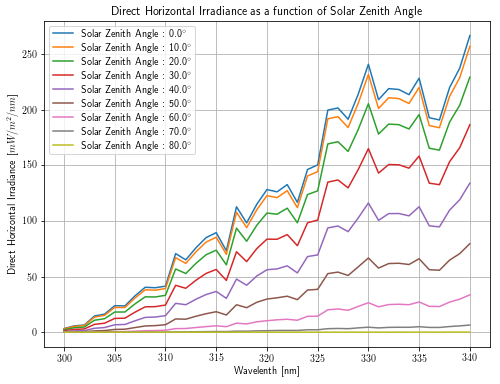

In [49]:
# Plot direct irradiance for all 10 cases
plt.figure(figsize=(8,6))
plt.plot(libRadBatch[0].wvl, edir)
plt.title('Direct Horizontal Irradiance as a function of Solar Zenith Angle')
plt.xlabel('Wavelenth [nm]')
plt.ylabel('Direct Horizontal Irradiance [$' + 
           '/'.join(libRadBatch[0].rad_units)+ '$]')
the_legends = ['Solar Zenith Angle : ' + 
               str(leg) + '$^\circ$' for leg in 
               solar_zenith_angle]
plt.legend(the_legends)
plt.grid()

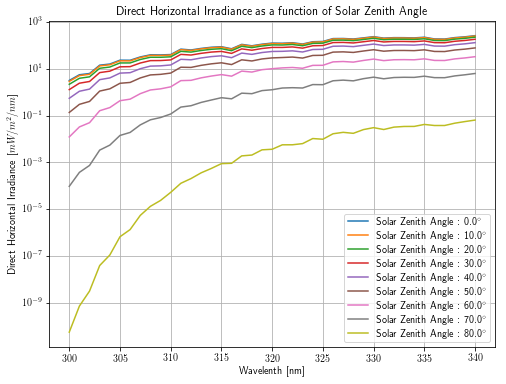

In [54]:
# Repeat plot, but on log scale
# Plot direct irradiance for all 10 cases
plt.figure(figsize=(8,6))
plt.semilogy(libRadBatch[0].wvl, edir)
plt.title('Direct Horizontal Irradiance as a function of Solar Zenith Angle')
plt.xlabel('Wavelenth [nm]')
plt.ylabel('Direct Horizontal Irradiance [$' + 
           '/'.join(libRadBatch[0].rad_units)+ '$]')
the_legends = ['Solar Zenith Angle : ' + str(leg) + 
               '$^\circ$' for leg in solar_zenith_angle]
plt.legend(the_legends)
plt.grid()

In [55]:
import datetime
now = datetime.datetime.now()
print 'Completed Run at ', str(now)
# After executing this cell, save the notebook before running the
# publish cells below
# To run the complete notebook, select this cell
# and then choose Cell->Run All Above from the menu

Completed Run at  2018-03-15 12:06:51.111000


In [56]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'" + thename + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [57]:
publish = True
casename = 'Dask.Distributed.Example'
casetitle = 'Computation of Direct Horizontal Ultraviolet Irradiance'
subtitle = 'Variation with Solar Zenith Angle'
result_folder = 'd:/Projects/MORTICIA/Docs/ReportFY201718/Appendices'
# Run this cell to publish, but save the notebook beforehand
# The contents of this cell strictly for publishing the notebook.
if publish:
    notebook_name = theNotebook + '.ipynb'
    # Run nbconvert to create a tex file as well as pdf graphic files
    !jupyter nbconvert --to latex $notebook_name
    # Do touchups
    def touchup_build_tex(tex_file, touchups):
        # Read the LaTeX file
        f = open(tex_file,'r')
        filedata = f.read()
        f.close()
        # Perform touchups
        for src, target in touchups.iteritems():
            filedata = filedata.replace(src, target)
        # Write file again
        f = open(tex_file,'w')
        f.write(filedata)
        f.close()
        # Build PDF using LaTeX
        !pdflatex $tex_file > pdflatex.out
        
    touchups = {'[11pt]{article}': '[11pt, a4paper, landscape]{scrartcl}',
            'title{' + theNotebook + '}':
            'title{' + casetitle + '}' +
            '\subtitle{' + subtitle + '}'}
    touchup_build_tex(theNotebook + '.tex', touchups)
    # Move the compiled pdf to the results folder
    import os
    publication = result_folder + os.sep + casename + '.pdf'
    if os.path.exists(publication):
        os.remove(publication)
    os.rename(theNotebook + '.pdf', publication)

[NbConvertApp] Converting notebook 05b-libRadtran-dask-distributed.ipynb to latex
[NbConvertApp] Support files will be in 05b-libRadtran-dask-distributed_files\
[NbConvertApp] Making directory 05b-libRadtran-dask-distributed_files
[NbConvertApp] Making directory 05b-libRadtran-dask-distributed_files
[NbConvertApp] Writing 34563 bytes to 05b-libRadtran-dask-distributed.tex
